In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, MobileNetV2
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix
import os



load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

base_dir = '/content/drive/MyDrive/autism'


In [5]:
train_dir = '/content/drive/MyDrive/autism/train'
val_dir = '/content/drive/MyDrive/autism/valid'
test_dir = '/content/drive/MyDrive/autism/test'


\Load Data with ImageDataGenerator
python

In [6]:
IMG_SIZE = (200, 200)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')


Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Images shape: (32, 200, 200, 3)
Labels shape: (32, 2)


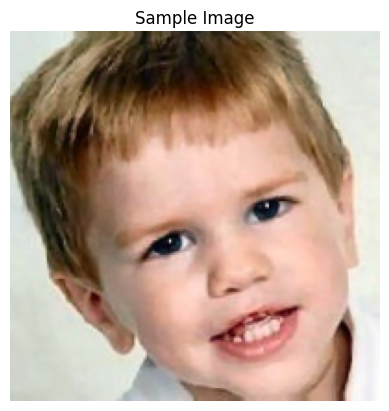

In [7]:
images, labels = next(train_gen)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Show just one image to confirm
plt.imshow(images[0])
plt.title("Sample Image")
plt.axis("off")
plt.show()


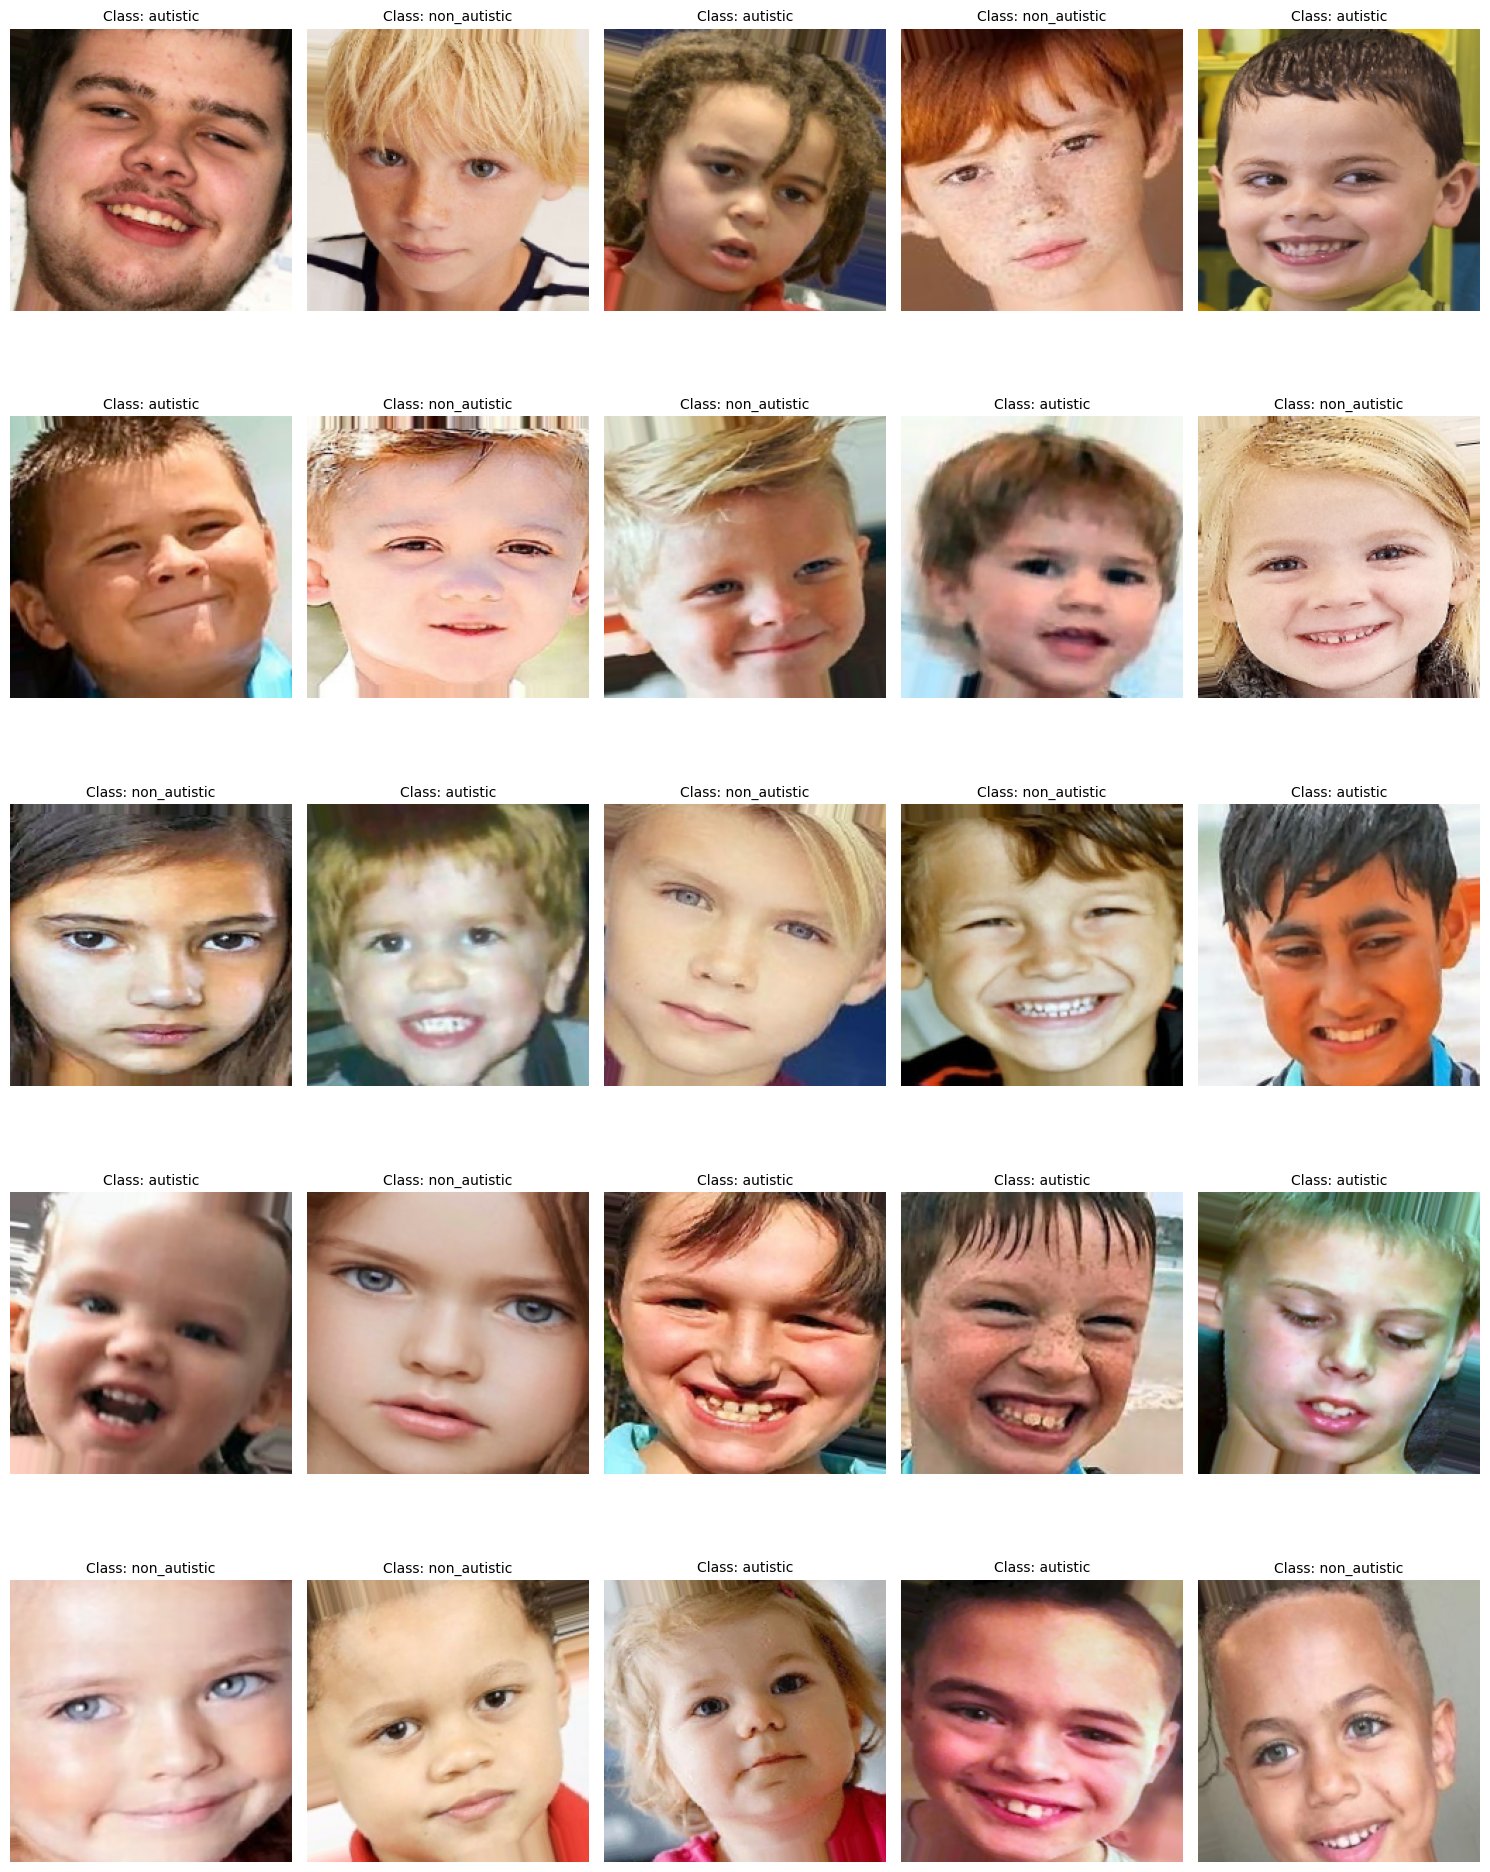

In [8]:
# Just get one batch of images and labels
images, labels = next(train_gen)

# Check class names
class_names = list(train_gen.class_indices.keys())

# Show 9 images


plt.figure(figsize=(15, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    index = np.argmax(labels[i])
    class_name = class_names[index]
    plt.title(f"Class: {class_name}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()



 CNN Model

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Compile the Model
python
Copy
Edit


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Train the Model

In [11]:
history = model.fit(train_gen, epochs=20, validation_data=val_gen)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 776s 10s/step - accuracy: 0.5435 - loss: 0.8808 - val_accuracy: 0.5750 - val_loss: 0.6862
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 439ms/step - accuracy: 0.6683 - loss: 0.6087 - val_accuracy: 0.6500 - val_loss: 0.6166
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - accuracy: 0.6638 - loss: 0.6057 - val_accuracy: 0.7000 - val_loss: 0.5890
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - accuracy: 0.7277 - loss: 0.5579 - val_accuracy: 0.6600 - val_loss: 0.5986
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 441ms/step - accuracy: 0.7119 - loss: 0.5707 - val_accuracy: 0.6700 - val_loss: 0.5691
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 431ms/step - accuracy: 0.7365 - loss: 0.5327 - val_accuracy: 0.6800 - val_loss: 0.5858
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - accuracy: 0.7513 - loss: 0.5153 - val_accuracy: 0.7150 - val_loss: 0.5531
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 444ms/step - accuracy: 0.7678 - loss: 0.5105 - val_accur

Evaluate on Test Set

In [12]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.8215 - loss: 0.3669
Test Accuracy: 81.50%


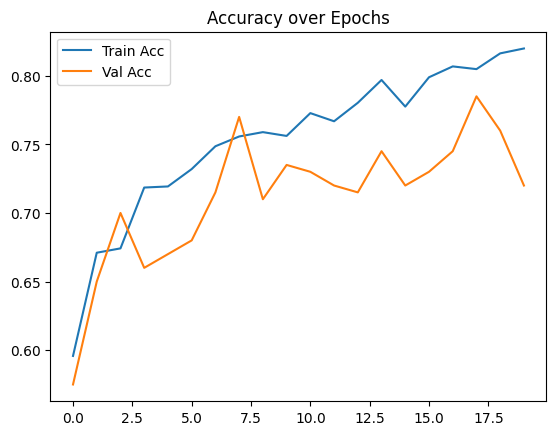

In [13]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


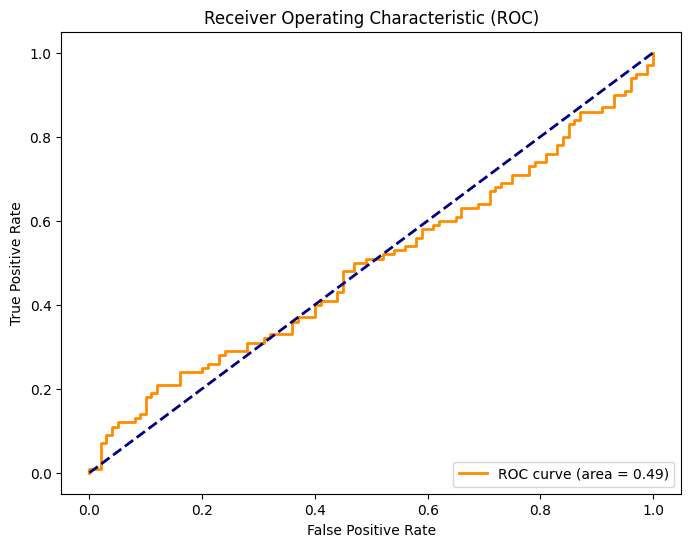

In [14]:
# Predict probabilities instead of classes
y_pred_prob = model.predict(test_gen, verbose=1)

# Get probabilities for the positive class only (assuming class 1 is positive)
y_pred_prob_positive = y_pred_prob[:, 1]

# Binarize labels (because you have two classes: 0 and 1)
y_true_bin = label_binarize(test_gen.classes, classes=[0, 1])

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_bin, y_pred_prob_positive)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [15]:
model.save('asd_cnn_model.h5')


In [16]:
# ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze base model layers
resnet_base.trainable = False

# Add custom layers on top
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Build and compile model
resnet_model = Model(inputs=resnet_base.input, outputs=output)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# MobileNetV2 Model
mobile_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze base model layers
mobile_base.trainable = False

# Add custom layers on top
x = mobile_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense( 2 , activation='softmax')(x)

# Build and compile model
mobile_model = Model(inputs=mobile_base.input, outputs=output)
mobile_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


<ipython-input-17-62da475be359>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Train ResNet50
history_resnet = resnet_model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 669ms/step - accuracy: 0.4828 - loss: 0.9018 - val_accuracy: 0.5100 - val_loss: 0.6880
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 466ms/step - accuracy: 0.5339 - loss: 0.7131 - val_accuracy: 0.5700 - val_loss: 0.6836
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - accuracy: 0.5317 - loss: 0.6965 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 468ms/step - accuracy: 0.5429 - loss: 0.6873 - val_accuracy: 0.5900 - val_loss: 0.6797
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - accuracy: 0.5705 - loss: 0.6830 - val_accuracy: 0.5550 - val_loss: 0.6794
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 462ms/step - accuracy: 0.5646 - loss: 0.6828 - val_accuracy: 0.5800 - val_loss: 0.6766
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 461ms/step - accuracy: 0.5766 - loss: 0.6790 - val_accuracy: 0.5700 - val_loss: 0.6753
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.6117 - loss: 0.6689 - val_accu

In [19]:



# Train MobileNetV2
history_mobile = mobile_model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 558ms/step - accuracy: 0.5521 - loss: 0.7954 - val_accuracy: 0.6850 - val_loss: 0.6012
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 438ms/step - accuracy: 0.6584 - loss: 0.6301 - val_accuracy: 0.7550 - val_loss: 0.5568
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 439ms/step - accuracy: 0.6847 - loss: 0.5843 - val_accuracy: 0.7550 - val_loss: 0.5386
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 424ms/step - accuracy: 0.7307 - loss: 0.5314 - val_accuracy: 0.7700 - val_loss: 0.5184
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 424ms/step - accuracy: 0.7520 - loss: 0.5055 - val_accuracy: 0.7850 - val_loss: 0.5071
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - accuracy: 0.7551 - loss: 0.5069 - val_accuracy: 0.7800 - val_loss: 0.5060
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 422ms/step - accuracy: 0.7499 - loss: 0.5229 - val_accuracy: 0.7850 - val_loss: 0.4983
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 435ms/step - accuracy: 0.7556 - loss: 0.4958 - val_accu

In [20]:
# Evaluate ResNet50
resnet_loss, resnet_acc = resnet_model.evaluate(test_gen)
print(f"ResNet50 Test Accuracy: {resnet_acc:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7030 - loss: 0.6426
ResNet50 Test Accuracy: 0.7100


In [21]:
# Evaluate MobileNetV2
mobile_loss, mobile_acc = mobile_model.evaluate(test_gen)
print(f"MobileNetV2 Test Accuracy: {mobile_acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7768 - loss: 0.4347
MobileNetV2 Test Accuracy: 0.7950


In [22]:
model.save("mobilenet_model.h5")


In [23]:
model.save("resnet_model.h5")


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 654ms/step


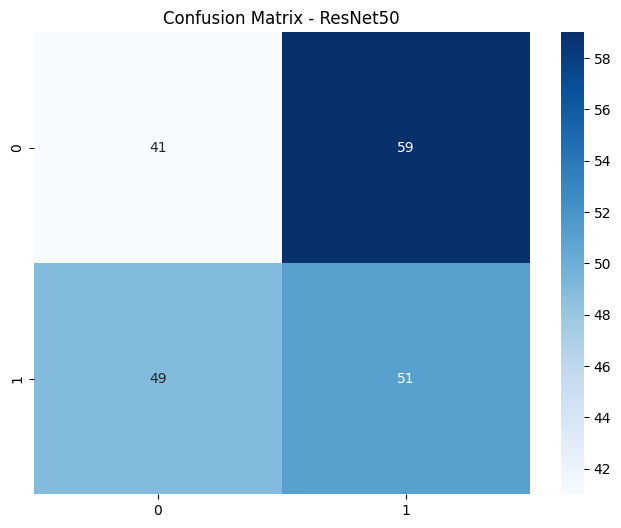

In [24]:


# Predict and Confusion Matrix for ResNet
preds_resnet = resnet_model.predict(test_gen)
pred_labels_resnet = preds_resnet.argmax(axis=1)

cm_resnet = confusion_matrix(test_gen.labels, pred_labels_resnet)

plt.figure(figsize=(8,6))
sns.heatmap(cm_resnet, annot=True, cmap="Blues", fmt="g")
plt.title('Confusion Matrix - ResNet50')
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


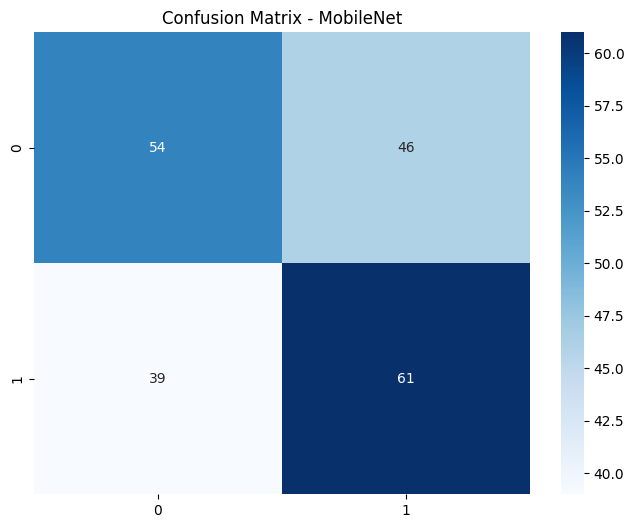

In [26]:


# Predict and Confusion Matrix for mobileNet
preds_mobile = mobile_model.predict(test_gen)
pred_labels_mobile = preds_mobile.argmax(axis=1)

cm_mobile = confusion_matrix(test_gen.labels, pred_labels_mobile)

plt.figure(figsize=(8,6))
sns.heatmap(cm_mobile, annot=True, cmap="Blues", fmt="g")
plt.title('Confusion Matrix - MobileNet')
plt.show()

